# Using vtreat with Classification Problems

## Preliminaries

Load modules/packages.

In [1]:
import pkg_resources
import pandas
import numpy
import numpy.random
import seaborn
import matplotlib.pyplot as plt
import vtreat
import vtreat.util
import wvpy.util

Generate example data. 

* `y` is a noisy sinusoidal function of the variable `x`
* `yc` is the output to be predicted: : whether `y` is > 0.5. 
* Input `xc` is a categorical variable that represents a discretization of `y`, along some `NaN`s
* Input `x2` is a pure noise variable with no relationship to the output

In [2]:
def make_data(nrows):
    d = pandas.DataFrame({'x':[0.1*i for i in range(500)]})
    d['y'] = numpy.sin(d['x']) + 0.1*numpy.random.normal(size=d.shape[0])
    d['xc'] = ['level_' + str(5*numpy.round(yi/5, 1)) for yi in d['y']]
    d['x2'] = numpy.random.normal(size=d.shape[0])
    d.loc[d['xc']=='level_-1.0', 'xc'] = numpy.nan # introduce a nan level
    d['yc'] = d['y']>0.5
    return d

d = make_data(500)

d.head()

,x,y,xc,x2,yc
0,0.0,0.052334,level_0.0,1.228502,False
1,0.1,0.116271,level_0.0,1.043923,False
2,0.2,0.040734,level_0.0,-0.737514,False
3,0.3,0.300033,level_0.5,0.324894,False
4,0.4,0.120454,level_0.0,-0.932343,False


### Some quick data exploration

Check how many levels `xc` has, and their disribution (including `NaN`)

In [3]:
d['xc'].unique()

array(['level_0.0', 'level_0.5', 'level_1.0', 'level_-0.0', 'level_-0.5',
       nan], dtype=object)

In [4]:
d['xc'].value_counts(dropna=False)

NaN           118
level_1.0     111
level_0.5     100
level_-0.5     92
level_0.0      40
level_-0.0     39
Name: xc, dtype: int64

Find the mean value of `yc`

In [5]:
numpy.mean(d['yc'])

0.336

Plot of `yc` versus `x`.

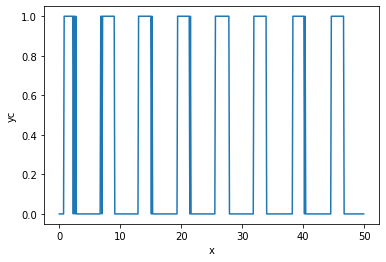

In [6]:
seaborn.lineplot(x='x', y='yc', data=d)

## Build a transform appropriate for classification problems.

Now that we have the data, we want to treat it prior to modeling: we want training data where all the input variables are numeric and have no missing values or `NaN`s.

First create the data treatment transform object, in this case a treatment for a binomial classification problem.

In [7]:
transform = vtreat.BinomialOutcomeTreatment(
    outcome_name='yc',    # outcome variable
    outcome_target=True,  # outcome of interest
    cols_to_copy=['y'],   # columns to "carry along" but not treat as input variables
)  

Use the training data 'd' to fit the transform and the return a treated training set: completely numeric, with no missing values.
Note that `transform.fit_transform()` is **not** the same as `transform.fit().transform()`; the second call can lead to nested model bias in some situations, and is **not** recommended.

In [8]:
d_prepared = transform.fit_transform(d, d['yc'])
d_prepared.head()

,y,yc,xc_is_bad,xc_logit_code,xc_prevalence_code,xc_lev__NA_,xc_lev_level_1.0,xc_lev_level_0.5,xc_lev_level_-0.5
0,0.052334,False,0.0,-5.738883,0.08,0.0,0.0,0.0,0.0
1,0.116271,False,0.0,-5.738883,0.08,0.0,0.0,0.0,0.0
2,0.040734,False,0.0,-5.723493,0.08,0.0,0.0,0.0,0.0
3,0.300033,False,0.0,0.532988,0.20,0.0,0.0,1.0,0.0
4,0.120454,False,0.0,-5.772389,0.08,0.0,0.0,0.0,0.0


Note that the variable `xc` has been converted to multiple variables: 

* an indicator variable for each possible level (`xc_lev_level_*`)
* the value of a (cross-validated) one-variable model for `yc` as a function of `xc` (`xc_logit_code`)
* a variable that returns how prevalent this particular value of `xc` is in the training data
* a variable indicating when `xc` was `NaN` in the original data (`xc_is_bad`)

Any or all of these new variables are available for downstream modeling.

Now examine the score frame, which gives information about each new variable, including its type, which original variable it is  derived from, its (cross-validated) correlation with the outcome, and its (cross-validated) significance as a one-variable linear model for the outcome. 

The `recommended` column indicates which variables are non constant (`has_range` == True) and have a significance value smaller than `default_threshold`. See the section *Deriving the Default Threholds* below for the reasoning behind the default thresholds. Recommended columns are intended as advice about which variables appear to be most likely to be useful in a downstream model. This advice is deliberately conservative, to reduce the possibility of mistakenly eliminating variables that may in fact be useful (although, obviously, it can still mistakenly eliminate variables that have a real but non-linear relationship to the output, as is the case with `x`, in  our example).

In [9]:
transform.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,default_threshold,recommended
0,xc_is_bad,xc,missing_indicator,False,True,-0.395362,3.723440e-20,1.0,0.20,True
1,x,x,clean_copy,False,True,-0.059082,1.871805e-01,2.0,0.10,False
2,x2,x2,clean_copy,False,True,0.041547,3.538779e-01,2.0,0.10,False
3,xc_logit_code,xc,logit_code,True,True,0.847712,3.162734e-139,1.0,0.20,True
4,xc_prevalence_code,xc,prevalence_code,False,True,0.317940,3.305104e-13,1.0,0.20,True
5,xc_lev__NA_,xc,indicator_code,False,True,-0.395362,3.723440e-20,4.0,0.05,True
6,xc_lev_level_1.0,xc,indicator_code,False,True,0.750933,8.585100e-92,4.0,0.05,True
7,xc_lev_level_0.5,xc,indicator_code,False,True,0.247704,1.992418e-08,4.0,0.05,True
8,xc_lev_level_-0.5,xc,indicator_code,False,True,-0.337792,8.247526e-15,4.0,0.05,True


Let's look at the variables that are and are not recommended:

In [10]:
# recommended variables
transform.score_frame_['variable'][transform.score_frame_['recommended']]

0             xc_is_bad
3         xc_logit_code
4    xc_prevalence_code
5           xc_lev__NA_
6      xc_lev_level_1.0
7      xc_lev_level_0.5
8     xc_lev_level_-0.5
Name: variable, dtype: object

In [11]:
# not recommended variables
transform.score_frame_['variable'][transform.score_frame_['recommended']==False]

1     x
2    x2
Name: variable, dtype: object

Notice that `d_prepared` only includes recommended variables (along with `y` and `yc`):

In [12]:
d_prepared.columns

Index(['y', 'yc', 'xc_is_bad', 'xc_logit_code', 'xc_prevalence_code',
       'xc_lev__NA_', 'xc_lev_level_1.0', 'xc_lev_level_0.5',
       'xc_lev_level_-0.5'],
      dtype='object')

This is `vtreat`s default behavior; to include all variables in the prepared data, set the parameter `filter_to_recommended` to False, as we show later, in the *Parameters for `BinomialOutcomeTreatment`* section below.

## A Closer Look at the Derived Variables

### `logit_code` variables

Variables of type `logit_code` are the outputs of a one-variable hierarchical logistic regression of a categorical variable (in our example, `xc`) against the centered output on the (cross-validated) treated training data. 

Let's see whether `xc_logit_code` makes a good one-variable model for `yc`. It has a large AUC:

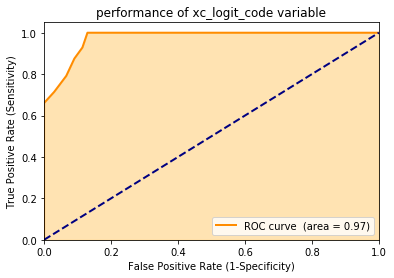

0.9747382386689616

In [13]:
wvpy.util.plot_roc(prediction=d_prepared['xc_logit_code'], 
                   istrue=d_prepared['yc'],
                   title = 'performance of xc_logit_code variable')

This indicates that `xc_logit_code` is strongly predictive of the outcome. Negative values of `xc_logit_code` correspond strongly to negative outcomes, and positive values correspond strongly to postive outcomes.

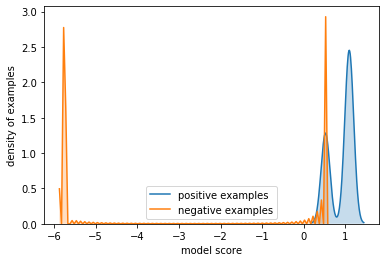

In [14]:
wvpy.util.dual_density_plot(probs=d_prepared['xc_logit_code'], 
                            istrue=d_prepared['yc'])

The values of `xc_logit_code` are in "link space". We can visualize the relationship a little better by converting the logistic score to a probability.

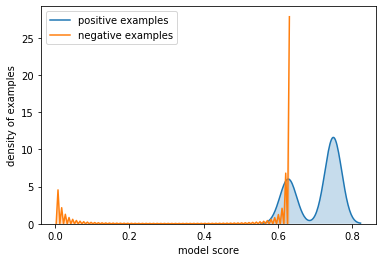

In [15]:
from scipy.special import expit  # sigmoid - remarkably, it works on Pandas data frame columns
wvpy.util.dual_density_plot(probs=expit(d_prepared['xc_logit_code']),
                            istrue=d_prepared['yc'])                                   

Variables of type `logit_code` are useful when dealing with categorical variables with a very large number of possible levels. For example, a categorical variable with 10,000 possible values potentially converts to 10,000 indicator variables, which may be unwieldy for some modeling methods. Using a single numerical variable of type `logit_code` may be a preferable alternative.

### `prevalence_code` variables

Variables of type `prevalence_code` encode how often each level of a categorical variable appears in the training data.

Let's look at `xc_prevalence_code`. It's also somewhat predictive (surprisingly).

First, get the contingency table of prevalence code value versus outcome value. The two variables are clearly not independent.

In [16]:
pandas.crosstab(d_prepared.xc_prevalence_code, d_prepared.yc)

yc,False,True
xc_prevalence_code,,
0.078,39,0
0.080,40,0
0.184,92,0
0.200,43,57
0.222,0,111
0.236,118,0


Next, look at the AUC and the distribution of scores graphically.

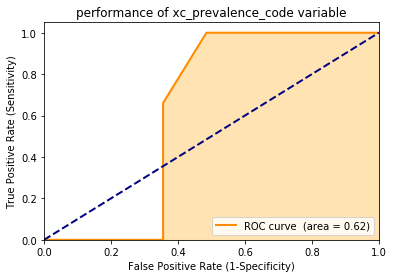

0.6226064974182445

In [17]:
wvpy.util.plot_roc(prediction=d_prepared['xc_prevalence_code'], 
                   istrue=d_prepared['yc'],
                   title = 'performance of xc_prevalence_code variable')

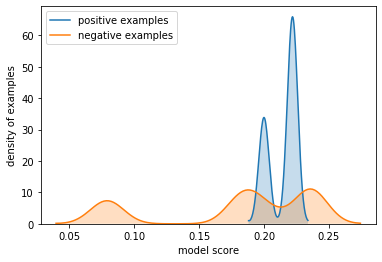

In [18]:
wvpy.util.dual_density_plot(probs=d_prepared['xc_prevalence_code'], 
                            istrue=d_prepared['yc'])

## Using the Prepared Data in a Model

Of course, what we really want to do with the prepared training data is to fit a model jointly with all the (recommended) variables. 
Let's try fitting a logistic regression model to `d_prepared`.

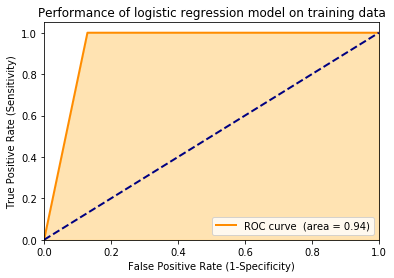

0.9352409638554217

In [19]:
import sklearn.linear_model
import seaborn

not_variables = ['y', 'yc', 'prediction']
model_vars = [v for v in d_prepared.columns if v not in set(not_variables)]

fitter = sklearn.linear_model.LogisticRegression()
fitter.fit(d_prepared[model_vars], d_prepared['yc'])

# now predict
d_prepared['prediction'] = fitter.predict(d_prepared[model_vars])

# look at the ROC curve (on the training data)
wvpy.util.plot_roc(prediction=d_prepared['prediction'], 
                   istrue=d_prepared['yc'],
                   title = 'Performance of logistic regression model on training data')

Now apply the model to new data.

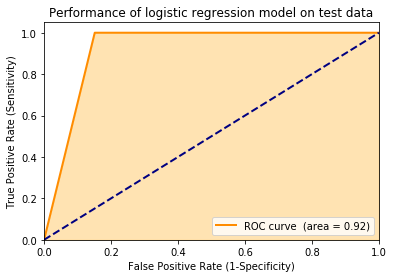

0.9243323442136498

In [20]:
# create the new data
dtest = make_data(450)

# prepare the new data with vtreat
dtest_prepared = transform.transform(dtest)

# apply the model to the prepared data
dtest_prepared['prediction'] = fitter.predict(dtest_prepared[model_vars])

wvpy.util.plot_roc(prediction=dtest_prepared['prediction'], 
                   istrue=dtest_prepared['yc'],
                   title = 'Performance of logistic regression model on test data')

## Parameters for `BinomialOutcomeTreatment`

We've tried to set the defaults for all parameters so that `vtreat` is usable out of the box for most applications.


In [21]:
vtreat.vtreat_parameters()

{'use_hierarchical_estimate': True,
 'coders': {'clean_copy',
  'deviation_code',
  'impact_code',
  'indicator_code',
  'logit_code',
  'missing_indicator',
  'prevalence_code'},
 'filter_to_recommended': True,
 'indicator_min_fraction': 0.1,
 'cross_validation_plan': <vtreat.cross_plan.KWayCrossPlan at 0x1a1b468978>,
 'cross_validation_k': 5,
 'user_transforms': [],
 'sparse_indicators': True}

**use_hierarchical_estimate:**: When True, uses hierarchical smoothing when estimating `logit_code` variables; when False, uses unsmoothed logistic regression.

**coders**: The types of synthetic variables that `vtreat` will (potentially) produce. See *Types of prepared variables* below.

**filter_to_recommended**: When True, prepared data only includes variables marked as "recommended" in score frame. When False, prepared data includes all variables. See the Example below.

**indicator_min_fraction**: For categorical variables, indicator variables (type `indicator_code`) are only produced for levels that are present at least `indicator_min_fraction` of the time. A consequence of this is that 1/`indicator_min_fraction` is the maximum number of indicators that will be produced for a given categorical variable. To make sure that *all* possible indicator variables are produced, set `indicator_min_fraction = 0`

**cross_validation_plan**: The cross validation method used by `vtreat`. Most people won't have to change this. *TODO: make some examples of OrderedCrossPlan and StratifiedCrossPlan to link to here*

**cross_validation_k**: The number of folds to use for cross-validation

**user_transforms**: For passing in user-defined transforms for custom data preparation. Won't be needed in most situations, but see [here](https://github.com/WinVector/pyvtreat/blob/master/Examples/UserCoders/UserCoders.ipynb) for an example of applying a GAM transform to input variables.

**sparse_indicators**: When True, use a (Pandas) sparse representation for indicator variables. This representation is compatible with `sklearn`; however, it may not be compatible with other modeling packages. When False, use a dense representation.

### Example: Use all variables to model, not just recommended

In [22]:
transform_all = vtreat.BinomialOutcomeTreatment(
    outcome_name='yc',    # outcome variable
    outcome_target=True,  # outcome of interest
    cols_to_copy=['y'],   # columns to "carry along" but not treat as input variables
    params = vtreat.vtreat_parameters({
        'filter_to_recommended': False
    })
)  

transform_all.fit_transform(d, d['yc']).columns

Index(['y', 'yc', 'xc_is_bad', 'x', 'x2', 'xc_logit_code',
       'xc_prevalence_code', 'xc_lev__NA_', 'xc_lev_level_1.0',
       'xc_lev_level_0.5', 'xc_lev_level_-0.5'],
      dtype='object')

In [23]:
transform_all.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,default_threshold,recommended
0,xc_is_bad,xc,missing_indicator,False,True,-0.395362,3.723440e-20,1.0,0.20,True
1,x,x,clean_copy,False,True,-0.059082,1.871805e-01,2.0,0.10,False
2,x2,x2,clean_copy,False,True,0.041547,3.538779e-01,2.0,0.10,False
3,xc_logit_code,xc,logit_code,True,True,0.847246,6.363659e-139,1.0,0.20,True
4,xc_prevalence_code,xc,prevalence_code,False,True,0.317940,3.305104e-13,1.0,0.20,True
5,xc_lev__NA_,xc,indicator_code,False,True,-0.395362,3.723440e-20,4.0,0.05,True
6,xc_lev_level_1.0,xc,indicator_code,False,True,0.750933,8.585100e-92,4.0,0.05,True
7,xc_lev_level_0.5,xc,indicator_code,False,True,0.247704,1.992418e-08,4.0,0.05,True
8,xc_lev_level_-0.5,xc,indicator_code,False,True,-0.337792,8.247526e-15,4.0,0.05,True


Note that the prepared data produced by `fit_transform()` includes all the variables, including those that were not marked as "recommended". 

## Types of prepared variables

**clean_copy**: Produced from numerical variables: a clean numerical variable with no `NaNs` or missing values

**indicator_code**: Produced from categorical variables, one for each (common) level: for each level of the variable, indicates if that level was "on"

**prevalence_code**: Produced from categorical variables: indicates how often each level of the variable was "on"

**logit_code**: Produced from categorical variables: score from a one-dimensional model of the centered output as a function of the variable

**missing_indicator**: Produced for both numerical and categorical variables: an indicator variable that marks when the original variable was missing or  `NaN`

**deviation_code**: not used by `BinomialOutcomeTreatment`

**impact_code**: not used by `BinomialOutcomeTreatment`

### Example: Produce only a subset of variable types

In this example, suppose you only want to use indicators and continuous variables in your model; 
in other words, you only want to use variables of types (`clean_copy`, `missing_indicator`, and `indicator_code`), and no `logit_code` or `prevalence_code` variables.

In [24]:
transform_thin = vtreat.BinomialOutcomeTreatment(
    outcome_name='yc',    # outcome variable
    outcome_target=True,  # outcome of interest
    cols_to_copy=['y'],   # columns to "carry along" but not treat as input variables
    params = vtreat.vtreat_parameters({
        'filter_to_recommended': False,
        'coders': {'clean_copy',
                   'missing_indicator',
                   'indicator_code',
                  }
    })
)

transform_thin.fit_transform(d, d['yc']).head()

,y,yc,xc_is_bad,x,x2,xc_lev__NA_,xc_lev_level_1.0,xc_lev_level_0.5,xc_lev_level_-0.5
0,0.052334,False,0.0,0.0,1.228502,0.0,0.0,0.0,0.0
1,0.116271,False,0.0,0.1,1.043923,0.0,0.0,0.0,0.0
2,0.040734,False,0.0,0.2,-0.737514,0.0,0.0,0.0,0.0
3,0.300033,False,0.0,0.3,0.324894,0.0,0.0,1.0,0.0
4,0.120454,False,0.0,0.4,-0.932343,0.0,0.0,0.0,0.0


In [25]:
transform_thin.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,default_threshold,recommended
0,xc_is_bad,xc,missing_indicator,False,True,-0.395362,3.723440e-20,1.0,0.333333,True
1,x,x,clean_copy,False,True,-0.059082,1.871805e-01,2.0,0.166667,False
2,x2,x2,clean_copy,False,True,0.041547,3.538779e-01,2.0,0.166667,False
3,xc_lev__NA_,xc,indicator_code,False,True,-0.395362,3.723440e-20,4.0,0.083333,True
4,xc_lev_level_1.0,xc,indicator_code,False,True,0.750933,8.585100e-92,4.0,0.083333,True
5,xc_lev_level_0.5,xc,indicator_code,False,True,0.247704,1.992418e-08,4.0,0.083333,True
6,xc_lev_level_-0.5,xc,indicator_code,False,True,-0.337792,8.247526e-15,4.0,0.083333,True


## Deriving the Default Thresholds

While machine learning algorithms are generally tolerant to a reasonable number of irrelevant or noise variables, too many irrelevant variables can lead to serious overfit; see [this article](http://www.win-vector.com/blog/2014/02/bad-bayes-an-example-of-why-you-need-hold-out-testing/) for an extreme example, one we call "Bad Bayes". The default threshold is an attempt to eliminate obviously irrelevant variables early.

Imagine that you have a pure noise dataset, where none of the *n* inputs are related to the output. If you treat each variable as a one-variable model for the output, and look at the significances of each model, these significance-values will be uniformly distributed in the range [0:1]. You want to pick a weakest possible significance threshold that eliminates as many noise variables as possible. A moment's thought should convince you that a threshold of *1/n* allows only one variable through, in expectation. 

This leads to the general-case heuristic that a significance threshold of *1/n* on your variables should allow only one irrelevant variable through, in expectation (along with all the relevant variables). Hence, *1/n* used to be our recommended threshold, when we developed the R version of `vtreat`.

We noticed, however, that this biases the filtering against numerical variables, since there are at most two derived variables (of types *clean_copy* and *missing_indicator* for every numerical variable in the original data. Categorical variables, on the other hand, are expanded to many derived variables: several indicators (one for every common level), plus a *logit_code* and a *prevalence_code*. So we now reweight the thresholds. 

Suppose you have a (treated) data set with *ntreat* different types of `vtreat` variables (`clean_copy`, `indicator_code`, etc).
There are *nT* variables of type *T*. Then the default threshold for all the variables of type *T* is *1/(ntreat nT)*. This reweighting  helps to reduce the bias against any particular type of variable. The heuristic is still that the set of recommended variables will allow at most one noise variable into the set of candidate variables.

As noted above, because `vtreat` estimates variable significances using linear methods by default, some variables with a non-linear relationship  to the output may fail to pass the threshold. Setting the `filter_to_recommended` parameter to False will keep all derived variables in the treated frame, for the data scientist to filter (or not) as they will.





